### Loading Library

In [1]:
#Load library
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import time
from math import sqrt
import random
import matplotlib as matplt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, normalize
from fastFM import als
from sklearn.metrics import mean_absolute_error, mean_squared_error

from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate

### Loading Data

In [2]:
#Load data
path = "/Users/yh3093/Desktop/Personalization/Final Project/Data/"

#Ratings
ratings = pd.read_csv(path+'ratings.dat', sep='::', header=None, engine='python')
ratings.columns = ['userId','movieId','rating','timestamp']
ratings = ratings.drop('timestamp', axis=1)

#Movies
movies = pd.read_csv(path+'movies.dat', sep='::', header=None, engine='python')
movies.columns = ['MovieID','Title','Genres']

#Users
users = pd.read_csv(path+'users.dat', sep='::', header=None, engine='python')
users.columns = ['UserID','Gender','Age','Occupation','Zip-code']

### Data Quality

In [3]:
#Data quality
print('Duplicated rows in ratings file: ' + str(ratings.duplicated().sum()))

n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of movies: {}'.format(n_movies))
print('Sparsity: {:4.3f}%'.format(float(ratings.shape[0]) / float(n_users*n_movies) * 100))

Duplicated rows in ratings file: 0
Number of users: 6040
Number of movies: 3706
Sparsity: 4.468%


### Functions used in the factorization machine training

In [4]:
#subset data
def subsetdata(data, by, subset_quantile):
    filter_standard = data.groupby([by]).size().reset_index(name='counts').counts.quantile(subset_quantile)
    subset_data = data.groupby(by).filter(lambda x: len(x) >= filter_standard)
    
    return filter_standard, subset_data

In [5]:
#split train and test data
def split_testtrain(ratings, fraction):
    #Transform data in matrix format
    colnames = ratings.columns.values
    new_colnames = ["1_user", "2_movie", "0_rating"]
    ratings = ratings.rename(index=str, columns=dict(zip(colnames, new_colnames)))
    
    ratings_df = ratings.to_dict(orient="records")
    
    dv = DictVectorizer()
    ratings_mat = dv.fit_transform(ratings_df).toarray()
    
    #Split data
    x_train, x_test, y_train, y_test = train_test_split(ratings_mat[:,1:], ratings_mat[:,:1], test_size=fraction)
    
    return x_train, x_test, y_train.T[0], y_test.T[0]

In [6]:
#One hot encoding
def OneHotEncoding(train,test):
    encoder = OneHotEncoder(handle_unknown='ignore').fit(train)
    train = encoder.transform(train)
    test = encoder.transform(test)
    return train, test

In [7]:
#Gridsearch for the optimal parameter
def param_selection(X, y, n_folds):
    start = time.time()
    grid_param = {  
    'n_iter' : np.arange(0,120,25)[1:],
    'rank' :  np.arange(2,12,4),
    }
    grid_search = GridSearchCV(als.FMRegression(l2_reg_w=0.1,l2_reg_V=0.1), cv=n_folds, param_grid=grid_param, verbose=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    print(time.time()-start)
    return grid_search.best_params_

In [8]:
def rec_coverage(x_test, y_test, prediction, rec_num):
    ratings = pd.DataFrame()
    ratings['user'] = x_test[:,0]
    ratings['movie'] = x_test[:,1]
    ratings['rating'] = y_test
    
    pred = ratings.copy()
    pred['rating'] = prediction
    
    rating_table = pd.pivot_table(ratings, index='user', columns = 'movie', values = 'rating')
    pred_table = pd.pivot_table(pred, index='user', columns = 'movie', values = 'rating')
    
    rec_movies = []
    rec = pred_table - rating_table
    for user in rec.index:
            rec_item = pred_table.loc[user,:].sort_values(ascending = False).head(rec_num).index.tolist()
            rec_movies += rec_item
    n_rec = len(set(rec_movies))
    n_movies = pred_table.shape[1]
    coverage = round(float(n_rec)/n_movies,2)
    
    return coverage

In [9]:
def create_plot(x1, x2, x3, y1, y2, y3, kind):
    pal = sns.color_palette("Set2")
    
    matplt.figure.Figure(figsize=(5000,5000))
    plt.plot(x1, y1, c=pal[0], label="Filter-User", linewidth=3)
    plt.plot(x2, y2, c=pal[1], label="Filter-Movie", linewidth=3)
    plt.plot(x3, y3, c=pal[2], label="Filter-Both", linewidth=3)
    plt.legend(loc='best', fontsize=12)
    plt.xticks(fontsize=12);
    plt.yticks(fontsize=12);
    plt.xlabel("Sampled Data Size", fontsize=14);
    plt.ylabel(kind, fontsize=14);
    plt.title(kind, loc='center', fontsize=16);
    plt.show()

### Factorization Machine

In [1]:
def FactorizationMachine(ratings, subset_by, subset_quantile):
    #Initialize output
    final_output = pd.DataFrame()
    result_dict = []
    n_iteration = 1 
    last_RMSE = 100
    threshold = 0
    
    for quantile in subset_quantile:
        print("---Running iteration " + str(n_iteration) + " ---")
        print("---Subsetting Original Data---")
        #subset original data
        if subset_by == "user":
            filter_standard, subset_ratings = subsetdata(ratings, "userId", quantile)
        elif subset_by == "movie":
            filter_standard, subset_ratings = subsetdata(ratings, "movieId", quantile)
        else:
            f1, subset_u = subsetdata(ratings, "userId", quantile)
            f2, subset_ratings = subsetdata(subset_u, "movieId", quantile)
            filter_standard = "("+str(f1)+","+str(f2)+")"
            
        n_users = subset_ratings.userId.unique().shape[0]
        n_movies = subset_ratings.movieId.unique().shape[0]
        n_size = subset_ratings.shape[0]*subset_ratings.shape[1]
        
        sparsity = round(float(subset_ratings.shape[0]) / float(n_users*n_movies),2)
        
        print("---Spliting Test and Train Data---")
        #split test and train data
        xtrain, xtest, ytrain, ytest = split_testtrain(subset_ratings, 0.2)

        print("---Encoding Data---")
        #encode data
        xtrain_enc, xtest_enc = OneHotEncoding(xtrain, xtest)

        print("---Hyperparameter Tuning---")
        #Find the optimal parameter by hyperparameter tuning
        start = time.time()
        params = param_selection(xtrain_enc, ytrain, 3)
        op_iter = params['n_iter']
        op_rank = params['rank']
        
        print("---Factorization Machine---")
        #Factorization machine
        fm = als.FMRegression(n_iter=op_iter, rank=op_rank, l2_reg_w=0.1, l2_reg_V=0.1)
        fm.fit(xtrain_enc, ytrain)
        predictions = fm.predict(xtest_enc)
        spent_time = time.time() - start
        #Evaluation metrics
        rmse = sqrt(mean_squared_error(ytest,predictions))
        mae = mean_absolute_error(ytest,predictions)
        coverage = rec_coverage(xtest, ytest, predictions, 10)
        
        if rmse < last_RMSE:
            last_RMSE = rmse
            threshold = filter_standard
            out = pd.DataFrame()
            out['user'] = xtest[:,0]
            out['movie'] = xtest[:,1]
            out['rating'] = ytest
            out['prediction'] = predictions
            
            final_output = out.copy()
            
        result_dict.append([quantile, filter_standard, n_size, n_users, n_movies, sparsity, op_iter, op_rank, spent_time, mae, rmse, coverage])
        n_iteration += 1
    
    results = pd.DataFrame(result_dict)
    results.columns = ["Quantile", "Threshold", "Size", "Num_Users", "Num_Movies", "Sparsity", "OP_Iter", "OP_Rank", "Running Time", "MAE", "RMSE", "Coverage"]
    
    final_output.to_csv("FM_Output_"+subset_by+"_"+str(threshold)+".csv", sep=',', encoding='utf-8', index=False)
    
    return results

In [11]:
quantile_list = np.arange(0.1,1,0.1)

### Subset method 1 - Subset data from less prolific users to prolific users

In [12]:
accuracy_matrix_user = FactorizationMachine(ratings, "user", quantile_list)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.357911252637, total=   3.7s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.363724745515, total=   3.7s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.366071744973, total=   3.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.296017178742, total=   7.8s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.283853833908, total=   7.8s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.291677769519, total=   7.8s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   35.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.173349848557, total=  12.0s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   47.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=10, score=0.17016387111, total=  11.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   59.6s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.178657003858, total=  11.8s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.365380822777, total=   7.5s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.364296006787, total=   7.2s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.366545889367, total=   7.2s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.300270444697, total=  15.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.292715799499, total=  15.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.292466303991, total=  15.3s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.151696733877, total=  23.6s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.6min finished


722.787038088
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.370760370338, total=   3.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.366921092798, total=   3.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.369699288332, total=   3.6s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.307391304508, total=   7.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.7s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.291801655297, total=   7.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.308937819294, total=   7.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   33.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.203078514909, total=  11.7s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.7s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.188458385721, total=  11.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   57.4s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.191697511533, total=  11.5s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.371265168997, total=   7.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.368344662299, total=   7.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] ............ n_iter=50, rank=2, score=0.3695914474, total=   7.2s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.307770293736, total=  14.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.290890508263, total=  14.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.308374172857, total=  14.8s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.190395187501, total=  22.6s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.2min finished


700.479765892
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.372606625322, total=   3.4s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.372949620884, total=   3.4s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.371064507152, total=   3.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.308240951221, total=   7.2s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.310622820192, total=   7.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.317141108069, total=   7.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   32.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=10, score=0.19664445828, total=  11.0s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   43.8s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.206724490078, total=  11.0s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   54.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.207260032327, total=  11.1s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.372598225489, total=   6.8s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.372899124834, total=   6.6s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.372629980975, total=   6.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.314477880283, total=  14.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.315456071285, total=  14.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] ........... n_iter=50, rank=6, score=0.32287437169, total=  14.3s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.178849264082, total=  21.9s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.8min finished


670.61405611
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.374608140648, total=   3.2s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.378240285009, total=   3.2s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.375673608949, total=   3.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.315041796877, total=   6.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.322078262787, total=   6.8s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.315863675846, total=   6.7s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   30.7s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.226370094643, total=  10.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   41.2s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.226757706982, total=  10.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   51.6s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.223684584492, total=  10.3s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s


[CV] ........... n_iter=50, rank=2, score=0.37487126011, total=   6.1s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.378004806288, total=   6.2s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.375371308177, total=   6.2s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.318917731412, total=  13.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] ........... n_iter=50, rank=6, score=0.32440729893, total=  13.4s
[CV] n_iter=50, rank=6 ...............................................
[CV] ........... n_iter=50, rank=6, score=0.32197482371, total=  13.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.213670211828, total=  20.7s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.1min finished


627.629582167
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.377468961455, total=   3.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ........... n_iter=25, rank=2, score=0.37120511298, total=   2.9s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.376797884602, total=   2.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.328036028895, total=   6.2s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.331021544056, total=   6.2s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.324097091416, total=   6.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   28.2s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.234232421085, total=   9.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   37.8s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.235247601109, total=   9.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   47.4s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.245538351803, total=   9.6s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   57.1s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.379859825333, total=   5.7s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.376202314392, total=   5.7s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.378369039185, total=   5.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.330787629072, total=  12.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.333346232527, total=  12.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.328330219906, total=  12.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.221713602985, total=  18.8s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  9.3min finished


578.295459986
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.372131365485, total=   2.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.372987287488, total=   2.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.381956056967, total=   2.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.334139339611, total=   5.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.339335563471, total=   5.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.9s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.33601288626, total=   5.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   24.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.237374504322, total=   8.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=10, score=0.24969960795, total=   8.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   41.3s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.249226512827, total=   8.4s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   49.7s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.376024076376, total=   4.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.376363061004, total=   4.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.382225656675, total=   4.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.334457739369, total=  10.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.342038712608, total=  10.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.335616582543, total=  10.7s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.224850483609, total=  16.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  8.2min finished


505.154567003
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.384068437529, total=   2.1s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.385145571429, total=   2.1s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.383895118277, total=   2.2s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.342485076448, total=   4.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.347256256362, total=   4.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.9s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.34433627978, total=   4.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.257587344413, total=   7.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   28.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.253439080535, total=   7.0s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   35.1s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.250493952797, total=   6.8s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   42.0s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.383938449004, total=   4.3s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.385561064433, total=   4.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.383765493684, total=   4.0s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.343615508753, total=   9.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.346293640796, total=   9.0s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.342830399279, total=   8.8s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.248235330044, total=  14.5s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.8min finished


423.498339176
---Factorization Machine---
---Running iteration 8 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.385190143937, total=   1.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.390671433975, total=   1.5s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.387614641256, total=   1.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.345601899612, total=   3.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.350005210813, total=   3.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.328897331036, total=   3.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   14.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.244459895426, total=   5.1s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   20.1s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.251289502874, total=   5.2s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.4s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.239552745293, total=   5.2s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.6s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.384469967896, total=   2.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.390567983178, total=   3.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] ........... n_iter=50, rank=2, score=0.38718798982, total=   3.0s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.342748651783, total=   6.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.344664218162, total=   6.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.334747865966, total=   6.7s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.227594473638, total=  10.2s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  5.0min finished


300.795085192
---Factorization Machine---
---Running iteration 9 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.381815283878, total=   0.8s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ........... n_iter=25, rank=2, score=0.37979092657, total=   0.8s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.386250651145, total=   0.8s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.30012880634, total=   1.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.306476350052, total=   1.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.302609597276, total=   1.7s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.7s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.176615002525, total=   2.7s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.4s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.198553703209, total=   2.6s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.1s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.173401736084, total=   2.6s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.7s remaining:    0.0s


[CV] ........... n_iter=50, rank=2, score=0.37954081501, total=   1.5s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.379618195925, total=   1.5s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.387121015324, total=   1.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.288097372138, total=   3.4s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.294310680367, total=   3.4s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.294519826743, total=   3.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.125232125674, total=   5.2s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.5min finished


153.8979702
---Factorization Machine---


In [13]:
accuracy_matrix_user

,Quantile,Threshold,Size,Num_Users,Num_Movies,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,27.0,2962770,5487,3702,0.05,100,2,749.441904,0.686313,0.874893,0.72
1,0.2,38.0,2900388,4835,3696,0.05,100,2,726.522744,0.686174,0.874300,0.68
2,0.3,51.0,2822913,4247,3689,0.06,100,2,695.690486,0.683980,0.871808,0.63
3,0.4,70.0,2712915,3631,3675,0.07,100,2,650.548518,0.684410,0.873204,0.55
4,0.5,96.0,2564124,3021,3671,0.08,100,2,599.391069,0.681567,0.868711,0.47
5,0.6,126.0,2369244,2429,3669,0.09,75,2,520.152280,0.681011,0.866332,0.41
6,0.7,173.0,2096814,1815,3663,0.11,100,2,440.161048,0.683118,0.868404,0.35
7,0.8,253.0,1721385,1215,3653,0.13,25,2,303.727144,0.679628,0.865176,0.27
8,0.9,400.0,1144221,605,3624,0.17,25,2,155.485739,0.683905,0.872241,0.20


In [14]:
#size_norm_u = normalize(accuracy_matrix_user['Size'][:,np.newaxis], axis=0).ravel()
size_norm_u = 1-np.array(accuracy_matrix_user['Quantile'])

In [15]:
time_u = np.array(accuracy_matrix_user['Running Time'])
mae_u = np.array(accuracy_matrix_user['MAE'])
rmse_u = np.array(accuracy_matrix_user['RMSE'])
coverage_u = np.array(accuracy_matrix_user['Coverage'])

### Subset method 2 - Subset data from less popular items to popular items

In [16]:
accuracy_matrix_movie = FactorizationMachine(ratings, "movie", quantile_list)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.361294361769, total=   3.8s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.361372531607, total=   3.8s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.362866087129, total=   3.8s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.289246473802, total=   8.0s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.279287959748, total=   8.0s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.282780295449, total=   8.0s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   36.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.170036124146, total=  12.2s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   48.3s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.161725750411, total=  12.1s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.173902262144, total=  12.2s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.360662382883, total=   7.3s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.362010086954, total=   7.4s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.362560963929, total=   7.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.292668818021, total=  16.2s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.273338797767, total=  15.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.279390231712, total=  16.0s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.149091279612, total=  24.5s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.9min finished


741.068608999
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... n_iter=25, rank=2, score=0.36566584364, total=   3.8s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.366836859552, total=   3.7s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.367157009865, total=   3.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.291830882465, total=   7.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.291396002632, total=   7.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.292877572086, total=   7.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   35.6s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.179406809116, total=  12.2s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   48.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.168154577373, total=  12.0s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.171410325807, total=  12.0s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.364423945909, total=   7.3s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.366592353779, total=   7.4s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.366474166866, total=   7.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] ........... n_iter=50, rank=6, score=0.28766856079, total=  15.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.289980964277, total=  15.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.288182221311, total=  15.5s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.157099391207, total=  23.9s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.8min finished


713.31160903
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.366574842917, total=   3.7s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.367686688991, total=   3.8s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.367869741914, total=   3.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.294171484652, total=   7.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.3s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.29736787755, total=   7.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.294613141181, total=   7.7s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   35.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.178951904531, total=  11.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   47.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.175707882622, total=  11.8s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   58.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.182614920714, total=  11.7s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.365445767508, total=   7.1s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.366360304532, total=   7.2s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.366607959567, total=   7.1s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.292606859784, total=  15.1s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.293665984111, total=  15.2s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.288051522183, total=  15.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.148412894121, total=  23.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.5min finished


695.191555023
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... n_iter=25, rank=2, score=0.36765302417, total=   3.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.366279947292, total=   3.5s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.367465679699, total=   3.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.301302060757, total=   7.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.300594633857, total=   7.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.302606268771, total=   7.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   33.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.198333275613, total=  11.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.201426452885, total=  11.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   56.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.190926397583, total=  11.4s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.366929302017, total=   6.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.365302484011, total=   6.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.366593584183, total=   6.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.291966316482, total=  14.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.292837106391, total=  14.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] ........... n_iter=50, rank=6, score=0.29532012897, total=  14.7s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.169101474132, total=  22.9s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.1min finished


670.793823957
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.356231333383, total=   3.4s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.360951515267, total=   3.4s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.360733726817, total=   3.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.307141452153, total=   7.1s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.309636061735, total=   7.1s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.310602859235, total=   7.1s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   32.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.201657868385, total=  10.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   43.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.195808554712, total=  10.8s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   53.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.200256746426, total=  10.8s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.355000964773, total=   6.5s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.359997128861, total=   6.5s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.359785070652, total=   6.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.298476373583, total=  14.1s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.301403337086, total=  13.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.306688013306, total=  13.9s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.168606508291, total=  21.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.5min finished


638.484929085
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.345818974145, total=   3.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.346454426621, total=   3.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.347203703494, total=   3.0s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.294214884565, total=   6.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.8s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.29490013812, total=   6.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.304091688582, total=   6.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   28.8s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.194091947449, total=   9.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   38.8s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.195949096443, total=   9.8s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   48.7s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.197851643034, total=   9.8s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   58.6s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.344449256242, total=   6.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.345521899432, total=   5.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.345884518503, total=   5.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.293895233383, total=  12.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.287779019311, total=  12.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.294997125253, total=  12.7s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.162370097992, total=  19.5s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  9.6min finished


583.903298855
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.328932140482, total=   2.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ............ n_iter=25, rank=2, score=0.3327563324, total=   2.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.333439386863, total=   2.6s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.267380208723, total=   5.6s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.7s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.273726179138, total=   5.6s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.272435201811, total=   5.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   24.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.175788251209, total=   8.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   33.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.175161177692, total=   8.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   42.1s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.172799979914, total=   8.9s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   51.1s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.327884686257, total=   5.1s
[CV] n_iter=50, rank=2 ...............................................
[CV] ........... n_iter=50, rank=2, score=0.33137952118, total=   5.1s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.332321125463, total=   5.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.266117263454, total=  11.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] ............ n_iter=50, rank=6, score=0.2665789096, total=  10.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.264377326793, total=  11.0s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.142719003097, total=  16.8s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  8.3min finished


501.926968098
---Factorization Machine---
---Running iteration 8 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.302413020814, total=   1.9s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.299509882153, total=   2.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.301408014629, total=   1.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.219388442369, total=   4.2s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.223722304547, total=   4.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.229165533892, total=   4.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.0s remaining:    0.0s


[CV] ........ n_iter=25, rank=10, score=0.0970023004149, total=   6.7s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.7s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.117999449255, total=   6.6s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   32.4s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.114498721848, total=   6.4s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.9s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.302430397364, total=   3.7s
[CV] n_iter=50, rank=2 ...............................................
[CV] ........... n_iter=50, rank=2, score=0.29845046224, total=   3.8s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.302128628562, total=   3.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.202740674761, total=   8.6s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.211991221504, total=   8.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.218108492508, total=   8.5s
[CV] n_iter=50, rank=10 ..............................................
[CV] ........ n_iter=50, rank=10, score=0.0620353918198, total=  13.2s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.4min finished


388.560770035
---Factorization Machine---
---Running iteration 9 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.243994688157, total=   1.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.244893883422, total=   1.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] ........... n_iter=25, rank=2, score=0.22925600755, total=   1.0s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.129799345568, total=   2.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.121723097475, total=   2.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.102142757565, total=   2.2s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.1s remaining:    0.0s


[CV] ....... n_iter=25, rank=10, score=-0.0447528995137, total=   3.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.6s remaining:    0.0s


[CV] ....... n_iter=25, rank=10, score=-0.0419857046391, total=   3.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   17.1s remaining:    0.0s


[CV] ....... n_iter=25, rank=10, score=-0.0751335425411, total=   3.5s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   20.6s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.237198388781, total=   2.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.246107652147, total=   2.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.237540151856, total=   2.0s
[CV] n_iter=50, rank=6 ...............................................
[CV] ......... n_iter=50, rank=6, score=0.0996858779671, total=   4.4s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.110769890241, total=   4.4s
[CV] n_iter=50, rank=6 ...............................................
[CV] ......... n_iter=50, rank=6, score=0.0599410407235, total=   4.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] ........ n_iter=50, rank=10, score=-0.130739725426, total=   7.2s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.4min finished


205.252352953
---Factorization Machine---


In [17]:
accuracy_matrix_movie

,Quantile,Threshold,Size,Num_Users,Num_Movies,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,7.0,2997762,6040,3350,0.05,100,2,768.387588,0.684769,0.873540,0.76
1,0.2,23.0,2982309,6040,2976,0.06,25,2,720.118070,0.687614,0.876081,0.80
2,0.3,44.0,2945409,6040,2599,0.06,25,2,702.040619,0.684270,0.870966,0.85
3,0.4,74.0,2882481,6040,2234,0.07,25,2,677.310914,0.685198,0.873336,0.91
4,0.5,123.5,2771667,6040,1853,0.08,25,2,644.487662,0.684515,0.873163,0.95
5,0.6,188.0,2601477,6040,1485,0.10,25,2,589.564688,0.680416,0.867377,0.98
6,0.7,280.0,2344821,6040,1113,0.12,25,2,506.800628,0.676116,0.864399,0.99
7,0.8,429.0,1957905,6040,743,0.15,25,2,392.263612,0.675736,0.864208,1.00
8,0.9,729.5,1333902,6039,371,0.20,50,2,209.287818,0.677351,0.870083,1.00


In [18]:
#size_norm_m = normalize(accuracy_matrix_movie['Size'][:,np.newaxis], axis=0).ravel()
size_norm_m = 1-np.array(accuracy_matrix_movie['Quantile'])

In [19]:
time_m = np.array(accuracy_matrix_movie['Running Time'])
mae_m = np.array(accuracy_matrix_movie['MAE'])
rmse_m = np.array(accuracy_matrix_movie['RMSE'])
coverage_m = np.array(accuracy_matrix_movie['Coverage'])

### Subset method 3 - Subset data in both user and item directions

In [20]:
accuracy_matrix_both = FactorizationMachine(ratings, "both", quantile_list)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.369030623102, total=   3.7s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.361824647538, total=   3.7s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.360033036455, total=   3.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.298063103699, total=   7.8s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.6s remaining:    0.0s


[CV] .............. n_iter=25, rank=6, score=0.28743268, total=   7.8s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.280286054227, total=   7.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   35.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.171643790837, total=  12.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   47.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.177090622856, total=  11.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   60.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.164521317658, total=  11.9s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.368649266817, total=   7.2s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.362663440027, total=   7.3s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.360395560558, total=   7.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.300566071284, total=  15.4s
[CV] n_iter=50, rank=6 ...............................................
[CV] ............ n_iter=50, rank=6, score=0.2919690071, total=  15.4s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.279826530777, total=  15.4s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.151508405563, total=  23.6s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.6min finished


724.951406002
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.373500570529, total=   3.5s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ........... n_iter=25, rank=2, score=0.37503458821, total=   3.5s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.372917113169, total=   3.6s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.293061065847, total=   7.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.302145481513, total=   7.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.1s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.29242107433, total=   7.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   33.7s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.186287546412, total=  11.7s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.6s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.193821051378, total=  11.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   57.2s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.185284330077, total=  11.4s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.373206786131, total=   6.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.374841585751, total=   6.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.372251209014, total=   6.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.313216859072, total=  14.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.309013710536, total=  14.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.297887249219, total=  14.7s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.176679390894, total=  22.6s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.1min finished


675.13270402
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.377586855215, total=   3.4s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.379443713524, total=   3.3s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.379667297293, total=   3.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.321731969173, total=   7.1s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.6s remaining:    0.0s


[CV] ............. n_iter=25, rank=6, score=0.332117353, total=   7.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.332959782673, total=   7.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   32.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.227965710255, total=  11.1s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   43.7s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.225766489999, total=  11.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   55.2s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.223207044699, total=  11.2s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.377354089185, total=   6.6s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.379207342317, total=   6.5s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.379708427608, total=   6.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.321874746958, total=  14.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.340792147688, total=  14.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.330655816006, total=  14.5s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.204666369757, total=  22.3s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.9min finished


660.660757065
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.379109268633, total=   3.1s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.377873911807, total=   3.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.378621891981, total=   3.0s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.353594580023, total=   6.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.348046305231, total=   6.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.346987129043, total=   6.7s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.8s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.252562333914, total=  10.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   40.2s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.253839515184, total=  10.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   50.7s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.258614877931, total=  10.2s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.380371426604, total=   5.9s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.377373019693, total=   6.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.378430105338, total=   6.0s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.355438456134, total=  12.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.350481697581, total=  13.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.344864834771, total=  13.2s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.244057825306, total=  20.0s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  9.9min finished


606.873418093
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.372463589994, total=   2.6s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.380744562166, total=   2.5s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.375220518448, total=   2.6s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.9s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.355525378904, total=   5.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.365950954328, total=   5.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.356423522776, total=   5.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   24.4s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.281718593136, total=   8.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   32.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.292565512988, total=   8.3s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   41.3s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.279986232254, total=   8.6s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   50.0s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.372389607298, total=   5.1s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.380692786756, total=   5.0s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.375204122496, total=   5.0s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.357022871895, total=  10.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.365690913886, total=  10.6s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.358007725608, total=  10.7s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.266994233974, total=  16.6s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  8.1min finished


490.471540928
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.362919427232, total=   2.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.369309239995, total=   2.0s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.369186370913, total=   2.0s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.364182027191, total=   4.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.366140452779, total=   4.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.0s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.36601973798, total=   4.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=10, score=0.28920602661, total=   6.8s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   26.4s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.302848303828, total=   6.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.4s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.298704726067, total=   6.8s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.3s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.368941222759, total=   3.8s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.369643930071, total=   3.8s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.370985473839, total=   3.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.364653409096, total=   8.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.365486060507, total=   8.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.366745991304, total=   8.5s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.274508945893, total=  13.5s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.4min finished


393.667182922
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.363589538092, total=   1.4s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.359719354181, total=   1.3s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.361744804666, total=   1.3s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.2s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.36569679457, total=   2.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV] ........... n_iter=25, rank=6, score=0.36169508431, total=   2.9s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.358092232907, total=   2.9s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   13.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=10, score=0.31568942636, total=   4.5s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.5s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.308631711723, total=   4.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   22.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.315594266614, total=   4.4s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   26.4s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.363582542089, total=   2.6s
[CV] n_iter=50, rank=2 ...............................................
[CV] ........... n_iter=50, rank=2, score=0.35966342147, total=   2.5s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.361780912506, total=   2.5s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.365620435305, total=   5.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.361558813771, total=   5.7s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.362903871224, total=   5.7s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.314425319795, total=   8.6s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.3min finished


279.174984932
---Factorization Machine---
---Running iteration 8 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.344036698922, total=   0.7s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ........... n_iter=25, rank=2, score=0.35614846159, total=   0.7s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.359123245825, total=   0.7s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.350034460091, total=   1.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.360293148238, total=   1.5s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.362327052773, total=   1.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.6s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.289850641554, total=   2.2s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.8s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.309296267864, total=   2.2s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.0s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.308933766327, total=   2.2s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   13.2s remaining:    0.0s


[CV] .......... n_iter=50, rank=2, score=0.343896221958, total=   1.3s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.356203742952, total=   1.3s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.359171923351, total=   1.3s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.350889417037, total=   2.9s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.360450016023, total=   2.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.363978686809, total=   2.8s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.286812759958, total=   4.3s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.1min finished


137.450973034
---Factorization Machine---
---Running iteration 9 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Hyperparameter Tuning---
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... n_iter=25, rank=2, score=0.320433500496, total=   0.2s
[CV] n_iter=25, rank=2 ...............................................
[CV] .......... n_iter=25, rank=2, score=0.325339964135, total=   0.2s
[CV] n_iter=25, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .......... n_iter=25, rank=2, score=0.311854637649, total=   0.2s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.293128608503, total=   0.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.311954650475, total=   0.4s
[CV] n_iter=25, rank=6 ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s


[CV] .......... n_iter=25, rank=6, score=0.289407091569, total=   0.4s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.200059333943, total=   0.6s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.6s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.210333672339, total=   0.6s
[CV] n_iter=25, rank=10 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.2s remaining:    0.0s


[CV] ......... n_iter=25, rank=10, score=0.175948889397, total=   0.6s
[CV] n_iter=50, rank=2 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.9s remaining:    0.0s


[CV] ........... n_iter=50, rank=2, score=0.32419558731, total=   0.4s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.325900855926, total=   0.4s
[CV] n_iter=50, rank=2 ...............................................
[CV] .......... n_iter=50, rank=2, score=0.314162657051, total=   0.4s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.292027075101, total=   0.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.310224328749, total=   0.8s
[CV] n_iter=50, rank=6 ...............................................
[CV] .......... n_iter=50, rank=6, score=0.286089551696, total=   0.8s
[CV] n_iter=50, rank=10 ..............................................
[CV] ......... n_iter=50, rank=10, score=0.178421529643, total=   1.3s
[CV] n_iter=50, rank=10 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   37.7s finished


38.9504699707
---Factorization Machine---


In [21]:
accuracy_matrix_both

,Quantile,Threshold,Size,Num_Users,Num_Movies,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,"(27.0,7.0)",2959941,5487,3348,0.05,100,2,751.785283,0.684303,0.871027,0.74
1,0.2,"(38.0,23.0)",2881815,4835,2963,0.07,25,2,681.845055,0.685014,0.872640,0.75
2,0.3,"(51.0,43.0)",2768640,4247,2585,0.08,25,2,667.002248,0.680866,0.866233,0.75
3,0.4,"(70.0,72.0)",2598993,3631,2212,0.11,50,2,617.855748,0.676170,0.859887,0.73
4,0.5,"(96.0,113.0)",2354460,3021,1840,0.14,25,2,495.333612,0.674331,0.858769,0.71
5,0.6,"(126.0,162.0)",2023995,2429,1474,0.19,50,2,401.292872,0.671939,0.855438,0.68
6,0.7,"(173.0,216.0)",1579386,1815,1100,0.26,100,6,301.180441,0.651822,0.834315,0.81
7,0.8,"(253.0,269.0)",1032597,1215,735,0.39,100,6,148.646864,0.650656,0.832465,0.81
8,0.9,"(400.0,277.7)",398454,605,363,0.60,100,2,40.159568,0.665593,0.849393,0.73


In [22]:
#size_norm_b = normalize(accuracy_matrix_both['Size'][:,np.newaxis], axis=0).ravel()
size_norm_b = 1-np.array(accuracy_matrix_both['Quantile'])

In [23]:
time_b = np.array(accuracy_matrix_both['Running Time'])
mae_b = np.array(accuracy_matrix_both['MAE'])
rmse_b = np.array(accuracy_matrix_both['RMSE'])
coverage_b = np.array(accuracy_matrix_both['Coverage'])

### Benchmark model - Collaborative Filtering Using k-Nearest Neighbors (kNN) 

In [24]:
KNNdata = Dataset.load_builtin('ml-1m')

In [25]:
algo = KNNBasic()

In [26]:
cross_validate(algo, KNNdata, measures = ['MAE','RMSE'], cv = 3, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     0.7358  0.7344  0.7333  0.7345  0.0010  
RMSE (testset)    0.9324  0.9307  0.9291  0.9308  0.0013  
Fit time          20.23   20.68   20.37   20.43   0.19    
Test time         176.34  174.45  175.97  175.58  0.82    


{u'fit_time': (20.229735136032104, 20.681273937225342, 20.368288040161133),
 u'test_mae': array([0.73575109, 0.73442419, 0.73332891]),
 u'test_rmse': array([0.93244167, 0.9307044 , 0.92913824]),
 u'test_time': (176.33770990371704, 174.4471950531006, 175.96823501586914)}

### Evaluation

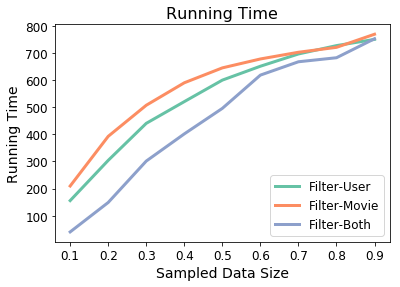

In [27]:
create_plot(size_norm_u, size_norm_m, size_norm_b, time_u, time_m, time_b, "Running Time")

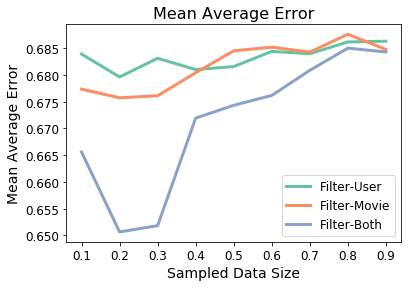

In [28]:
create_plot(size_norm_u, size_norm_m, size_norm_b, mae_u, mae_m, mae_b, "Mean Average Error")

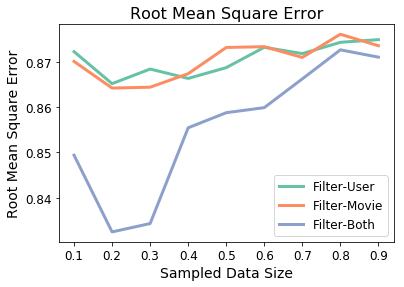

In [29]:
create_plot(size_norm_u, size_norm_m, size_norm_b, rmse_u, rmse_m, rmse_b, "Root Mean Square Error")

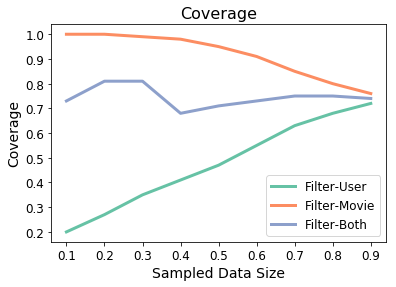

In [30]:
create_plot(size_norm_u, size_norm_m, size_norm_b, coverage_u, coverage_m, coverage_b, "Coverage")